# 3. Radial Basis Function Network Network

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize and load data

In [1]:
import pickle
from copy import deepcopy
from multiprocessing import Pool
from pathlib import Path
from functools import partial

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tqdm.contrib.itertools import product

from system_identification.utils.vdom import tabulate
from system_identification.rbfnn_model import RadialBasisFunctionNeuralNetworkModel
from system_identification.rbf_batch_trainer import RBFBatchTrainer

In [2]:
data = xr.open_dataset("data/data_smoothed.nc")
data

<xarray.Dataset>
Dimensions:                 (t: 10001, dim_0: 4, dim_1: 4, x_idx: 4,
                             all_samples: 10001, inputs: 2, m: 1, outputs: 1,
                             training_samples: 7001, validation_samples: 3000,
                             d0: 2, d1: 2)
Coordinates:
  * t                       (t) float64 0.0 0.01 0.02 0.03 ... 99.98 99.99 100.0
Dimensions without coordinates: dim_0, dim_1, x_idx, all_samples, inputs, m,
                                outputs, training_samples, validation_samples,
                                d0, d1
Data variables: (12/42)
    p_k1k1                  (t, dim_0, dim_1) float64 ...
    p_kk1                   (t, dim_0, dim_1) float64 ...
    phi                     (t, dim_0, dim_1) float64 ...
    gamma                   (t, dim_0, dim_1) float64 ...
    ps                      (t, dim_0, dim_1) float64 ...
    x_k1k1                  (t, x_idx) float64 ...
    ...                      ...
    alpha_estimate          (t) float64 ...
    training_inputs         (training_samples, inputs, m) float64 ...
    training_outputs        (training_samples, outputs, m) float64 ...
    validation_inputs       (validation_samples, inputs, m) float64 ...
    validation_outputs      (validation_samples, outputs, m) float64 ...
    input_range             (d0, d1) float64 ...

## 3.1 Linear Regression
The reconstructed F-16 dataset is approximated using a RBFNN. The RBF centers are placed in a uniform grid along the input range and amplitudes are estimated using Ordinary Least Squares (OLS).

### Hyperparameter optimization
The number of RBF's and widths need to be selected. To do this the number of RBF's and width in the grid is varied and the combination with the smallest absolute mean residual is chosen. For this part of the assignment.

In [4]:
rbf_per_side_list = list(range(1, 30, 1))
rbf_width_list = np.linspace(0.5, 20, 20)

shape = (len(rbf_per_side_list), len(rbf_width_list))
error_training_mean = np.empty(shape)
error_training_abs_mean = np.empty(shape)
error_training_jb = np.empty(shape)
error_training_jbp = np.empty(shape)
error_validation_mean = np.empty(shape)
error_validation_abs_mean = np.empty(shape)
error_validation_jb = np.empty(shape)
error_validation_jbp = np.empty(shape)

for (i, rbf_per_side), (j, rbf_width) in product(list(enumerate(rbf_per_side_list)), list(enumerate(rbf_width_list))):
    model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
        n_inputs=2,
        grid_size=[rbf_per_side, rbf_per_side],
        input_range=data.input_range.values,
        rbf_width=rbf_width,
        rbf_amplitude=1,
    )

    model.train(
        inputs=data.training_inputs.values,
        reference_outputs=data.training_outputs.values,
        validation_inputs=data.validation_inputs.values,
        validation_outputs=data.validation_outputs.values,
        method="trainlsqr",
    )
    
    error_training_abs_mean[i, j] = abs(model.training_log.error_training_data).mean()
    error_training_mean[i, j] = model.training_log.error_training_data.mean()
    error_training_jb[i, j] = model.training_log.error_training_jb.item()
    error_training_jbp[i, j] = model.training_log.error_training_jbp.item()
    
    error_validation_abs_mean[i, j] = abs(model.training_log.error_validation_data).mean()
    error_validation_mean[i, j] = model.training_log.error_validation_data.mean()
    error_validation_jb[i, j] = model.training_log.error_validation_jb.item()
    error_validation_jbp[i, j] = model.training_log.error_validation_jbp.item()
    

  0%|          | 0/580 [00:00<?, ?it/s]

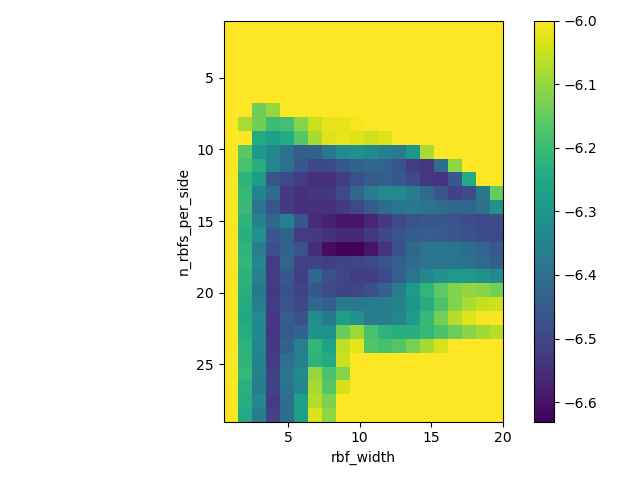

In [5]:
fig = plt.figure()
pos = plt.imshow(np.log(error_validation_abs_mean), vmax=-6 ,extent=(
    min(rbf_width_list),
    max(rbf_width_list),
    max(rbf_per_side_list),
    min(rbf_per_side_list),
))

plt.xlabel("rbf_width")
plt.ylabel("n_rbfs_per_side")

fig.colorbar(pos)

plt.tight_layout()

### Chosen case
The case with the smallest residual on the validation data was with 17 RBF's per side of the grid (189 RBF's) and a width or approximately 8.71. 

In [6]:
best_idxs = np.where(error_validation_abs_mean == error_validation_abs_mean.min())

tabulate({
    "rbf_per_side": rbf_per_side_list[int(best_idxs[0])],
    "rbf_width": rbf_width_list[int(best_idxs[1])],
    "error_validation_abs_mean": error_validation_abs_mean[int(best_idxs[0]), int(best_idxs[1])],
}, caption="Selected hyperparameters")

rbf_per_side,17.0
rbf_width,8.710526315789474
error_validation_abs_mean,0.0013193927113352168


In [7]:
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=2,
    grid_size=[17, 17],
    input_range=data.input_range.values,
    rbf_width=8.71,
    rbf_amplitude=1,
)

model.train(
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    method="trainlsqr",
)

### Results

In [8]:
tabulate(
    header=["identification data", "validation data"],
    row_header=['absolute residuals mean', 'residuals mean', "Jarque-Bera", "Jarque-Bera p-value"],
    data=[
        [abs(model.training_log.error_training_data).mean("i").item(),
         abs(model.training_log.error_validation_data).mean("j").item()],
        [model.training_log.error_training_data.mean("i").item(),
         model.training_log.error_validation_data.mean("j").item()],
        [model.training_log.error_training_jb.mean().item(),
         model.training_log.error_validation_jb.mean().item()],
        [model.training_log.error_training_jbp.mean().item(),
         model.training_log.error_validation_jbp.mean().item()]
    ]
)

,identification data,validation data
absolute residuals mean,0.001185493077275931,0.0013193991816258122
residuals mean,-1.8540584668188003e-07,0.00010125282948208268
Jarque-Bera,152.88266549040853,343.36293454244185
Jarque-Bera p-value,6.337981970472708e-34,2.7522388378988184e-75


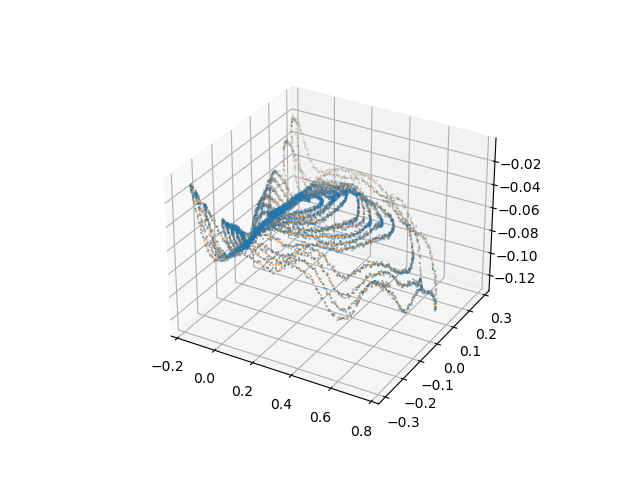

In [9]:
fig = plt.figure()
reference_inputs = data.training_inputs.values
reference_outputs = data.training_outputs.values
output = model.evaluate(reference_inputs)

ax = fig.add_subplot(projection='3d')
ax.scatter(reference_inputs[:, 0, 0], reference_inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(reference_inputs[:, 0, 0], reference_inputs[:, 1, 0], output.squeeze(), s=0.1)

## 3.2 Levenberg-Marquardt

The reconstructed F-16 dataset is approximated using a RBFNN. The RBF centers are initially placed in a uniform grid along the input range and the weights are given the same value as in the previous section.

The NN is then trained using the Levenberg-Marquardt (LM) learning algorithm to optimize the centers, widths and amplitudes.

### Identification

In [15]:
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=2,
    grid_size=[17, 17],
    input_range=data.input_range.values,
    rbf_width=8.71,
    rbf_amplitude=1,
)

In [16]:
model.train(
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    epochs=100,
    goal=1e-6,
    train_log_freq=1,
    method="trainlm",
    mu=10.,
    alpha=0.995
)

  0%|          | 0/100 [00:00<?, ?it/s]

/workspaces/system_identification/system_identification/rbfnn_model.py:495: RuntimeWarning: invalid value encountered in matmul
  delta_weights = np.linalg.inv(j.T @ j + mu * np.eye(j.shape[1])) @ j.T @ errors


In [12]:
model.training_log

<xarray.Dataset>
Dimensions:                (epoch: 100, i: 7001, j: 3000, k: 49, l: 49, m: 2,
                            n: 49, o: 2)
Coordinates:
  * epoch                  (epoch) int64 1 2 3 4 5 6 7 ... 94 95 96 97 98 99 100
Dimensions without coordinates: i, j, k, l, m, n, o
Data variables: (12/16)
    gradient               (epoch) float64 5.848e+04 1.317e+04 ... 1.116e+04
    error_training_data    (epoch, i) float64 -0.1526 -0.1533 ... 0.008411
    error_validation_data  (epoch, j) float64 -0.1546 -0.1513 ... 0.007689
    error_training_jb      (epoch) float64 8.292e+03 1.954e+04 ... 1.054e+03
    error_training_jbp     (epoch) float64 0.0 0.0 0.0 ... 3.063e-234 1.291e-229
    error_training_skew    (epoch) float64 -1.93 -2.218 ... -0.4827 -0.4788
    ...                     ...
    error_validation_kurt  (epoch) float64 6.627 7.542 6.407 ... 4.169 4.186
    weights_a              (epoch, k) float64 0.1553 0.1052 ... 0.5431 0.8857
    weights_c              (epoch, l, m) float64 -0.4738 -0.6633 ... 0.5435
    weights_w              (epoch, n, o) float64 8.712 8.712 ... 8.711 8.712
    min_residual_epoch     int64 100
    min_jb_epoch           int64 47

### Compare with OLS
We need to compare the LM and OLS trained models with each other, specifically the sensitivity to initial conditions. To do this we'll randomly generate some N number of models with random initial centers, widths and amplitude and compare the spread of results from the two methods.

In [5]:
def train_lm_and_ols(seed):
    """
    Trains the given model using both LB and OLS.
    
    :param seed: Seed used to generate the model.
    :returns: Tuple containing the LM and OLS trained models.
    """

    np.random.seed(seed)
    
    model_lm = RadialBasisFunctionNeuralNetworkModel.new_random_placement(
        n_inputs=2,
        n_hidden=50,
        input_range=data.input_range.values,
        width_range=(5, 15),
        amplitude_range=(0.5, 1.5),
    )
    
    # Copy the model so we know they both have the same initial condition.
    model_ols = deepcopy(model_lm)
    
    model_lm.train(
        inputs=data.training_inputs.values,
        reference_outputs=data.training_outputs.values,
        validation_inputs=data.validation_inputs.values,
        validation_outputs=data.validation_outputs.values,
        epochs=1000,
        goal=1e-6,
        train_log_freq=1,
        method="trainlm",
        mu=10.,
        alpha=0.995
    )
    
    model_ols.train(
        inputs=data.training_inputs.values,
        reference_outputs=data.training_outputs.values,
        validation_inputs=data.validation_inputs.values,
        validation_outputs=data.validation_outputs.values,
        method="trainlsqr",
    )
    
    return model_lm, model_ols

Training using LM for 1000 epochs lasts for roughly 3 mins on my laptop. So I'll be storing the intermediate results on disk in case it crashes during the process. This function is used to load the intermediate results into a pandas dataframe.

To speed up the process I'm also splitting it up in a processing pool. With 5 processes and assuming a 3min runtime per case, training 1000 models should last for roughly 10 hours.

In [6]:
lm_ols_comparison_path = Path("data/lm_ols_comparison_log.pickle")

def load_lm_ols_comparison_dataframe():
    log = []
    if lm_ols_comparison_path.exists():
        with lm_ols_comparison_path.open("rb") as f:
            while True:
                try:
                    entry = pickle.load(f)
                except EOFError:
                    break
                else:
                    log.append(entry)
    return pd.DataFrame(log)

In [ ]:
n_models = 1000


start_seed = len(load_lm_ols_comparison_dataframe())

with lm_ols_comparison_path.open("wb") as f:
    with tqdm(initial=start_seed, total=n_models) as pbar:
        for model_lm, model_ols in map(train_lm_and_ols, range(start_seed, n_models)):
            
            pbar.update()
            best_epoch = model_lm.training_log.min_residual_epoch.item()
            pickle.dump({
                "lm_best_epoch": best_epoch,

                "lm_residual_training_mean_absolute": abs(model_lm.training_log.error_training_data.sel(epoch=best_epoch)).mean("i").item(),
                "lm_residual_training_mean": model_lm.training_log.error_training_data.sel(epoch=best_epoch).mean("i").item(),
                "lm_residual_training_jb": abs(model_lm.training_log.error_training_jb.sel(epoch=best_epoch)).mean().item(),

                "lm_residual_validation_mean_absolute": abs(model_lm.training_log.error_validation_data.sel(epoch=best_epoch)).mean("j").item(),
                "lm_residual_validation_mean": model_lm.training_log.error_validation_data.sel(epoch=best_epoch).mean("j").item(),
                "lm_residual_validation_jb": model_lm.training_log.error_validation_jb.sel(epoch=best_epoch).item(),

                "ols_residual_training_mean_absolute": abs(model_ols.training_log.error_training_data).mean("i").item(),
                "ols_residual_training_mean": model_ols.training_log.error_training_data.mean("i").item(),
                "ols_residual_training_jb": abs(model_ols.training_log.error_training_jb).mean().item(),

                "ols_residual_validation_mean_absolute": abs(model_ols.training_log.error_validation_data).mean("j").item(),
                "ols_residual_validation_mean": model_ols.training_log.error_validation_data.mean("j").item(),
                "ols_residual_validation_jb": model_ols.training_log.error_validation_jb.item(),
            }, f)


In [64]:
df = load_lm_ols_comparison_dataframe()

In [65]:
len(df)

3

### Optimize cells

In [3]:
data_path = Path("data/test_results.pickle").absolute()
data_path

PosixPath('/workspaces/system_identification/work/data/test_results.pickle')

In [4]:
trainer = RBFBatchTrainer(    
    input_range=data.input_range.values,
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    epochs=250,
    goal=1e-6,
    train_log_freq=1,
    mu=10,
    alpha=0.995,
    method="trainlsqr",
    n_repeat=1,
    grid_sizes=list(reversed(range(1, 5, 1))),
    width_ranges=[(k, k) for k in np.linspace(0.5, 20, 5)],
    verbosity=1,
    path=data_path
)


In [5]:
results = trainer.train_batch()

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
results

<xarray.Dataset>
Dimensions:                            (grid_size: 4, width_range_min: 5)
Coordinates:
  * grid_size                          (grid_size) int64 1 2 3 4
  * width_range_min                    (width_range_min) float64 0.5 ... 20.0
Data variables:
    width_range_max                    (grid_size, width_range_min) float64 0...
    best_epoch                         (grid_size, width_range_min) float64 1...
    residual_training_mean_absolute    (grid_size, width_range_min) float64 0...
    residual_training_mean             (grid_size, width_range_min) float64 -...
    residual_training_jb               (grid_size, width_range_min) float64 1...
    residual_validation_mean_absolute  (grid_size, width_range_min) float64 0...
    residual_validation_mean           (grid_size, width_range_min) float64 -...
    residual_validation_jb             (grid_size, width_range_min) float64 1...

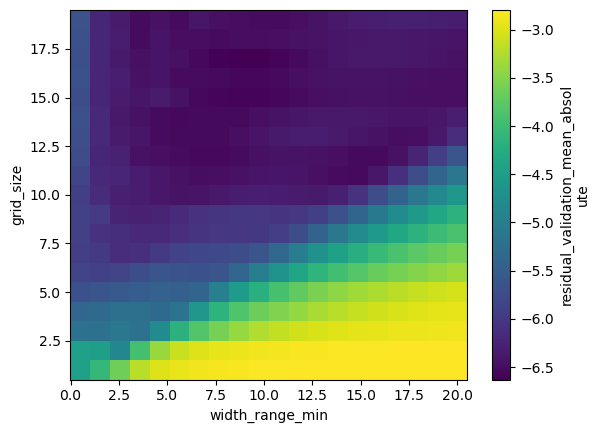

In [15]:
np.log(results.residual_validation_mean_absolute).plot()

In [15]:
model = optimizer.train_single(9, False)

NameError: name 'plot_model' is not defined

In [43]:
# model = RadialBasisFunctionNeuralNetworkModel.new_centroidal_voronoi_tessellation_placement(
#     n_hidden=50,
#     input_range=data.input_range.values,
#     width_range=(5, 15),
#     amplitude_range=(0.5, 1.5),
# )

model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=2,
    grid_size=[17, 17],
    input_range=data.input_range.values,
    rbf_width=8.71,
    rbf_amplitude=1,
)

# model.train(
#     inputs=data.training_inputs.values,
#     reference_outputs=data.training_outputs.values,
#     validation_inputs=data.validation_inputs.values,
#     validation_outputs=data.validation_outputs.values,
#     method="trainlsqr",
# )

# model = model.clone_clean()

model.train(
    inputs=data.training_inputs.values,
    reference_outputs=data.training_outputs.values,
    validation_inputs=data.validation_inputs.values,
    validation_outputs=data.validation_outputs.values,
    epochs=1000,
    goal=1e-6,
    train_log_freq=1,
    method="trainlm",
    mu=10.,
    alpha=0.9995
)

  0%|          | 0/1000 [00:00<?, ?it/s]

/workspaces/system_identification/system_identification/rbfnn_model.py:506: RuntimeWarning: invalid value encountered in matmul
  delta_weights = np.linalg.inv(j.T @ j + mu * np.eye(j.shape[1])) @ j.T @ errors


250


<RadialBasisFunctionNeuralNetwork
 n_inputs=2
 n_hidden=81
 n_outputs=1>

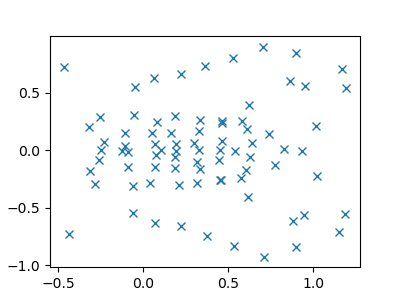

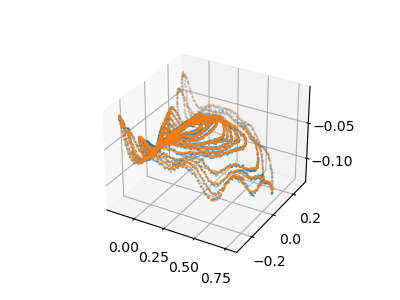

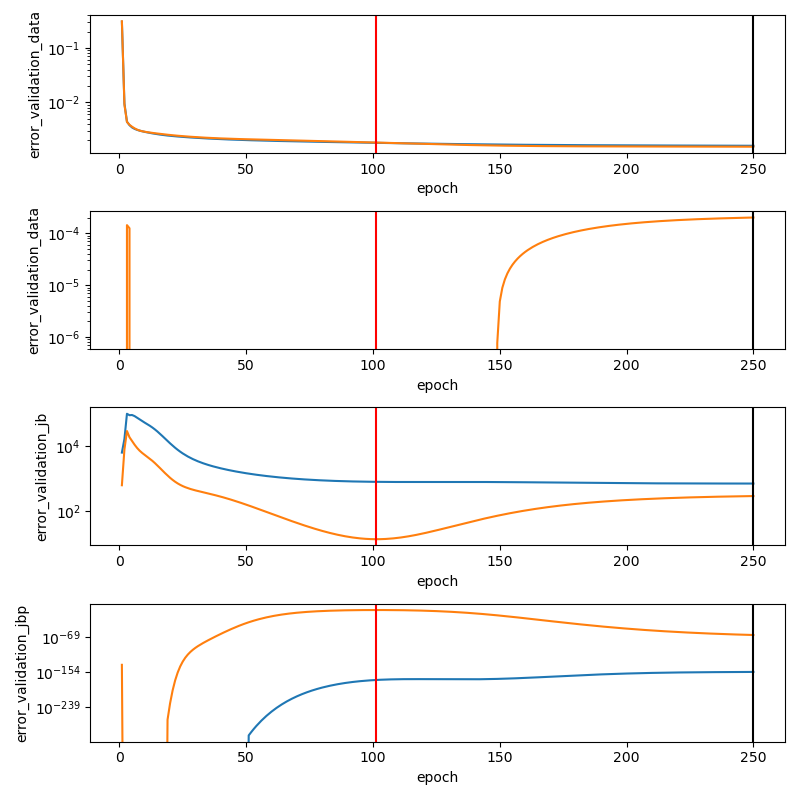

In [17]:
plot_model(model, epoch=model.training_log.min_residual_epoch)

### Results

In [7]:
def plot_model(model, epoch=None):
    """
    Plots the model state at the given epoch.
    
    :param model: Model to plot.
    :param epoch: Optional epoch at which to plot. By default it'll be the last epoch.
    """    
    if epoch is not None:
        model = RadialBasisFunctionNeuralNetworkModel.new_from_other_at_epoch(model, epoch)
    
    display(model)
    
    fig = plt.figure(figsize=(4, 3))
    plt.plot(model.weights_c[:, 0], model.weights_c[:, 1], "x")

    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(projection='3d')

    reference_inputs = data.training_inputs.values
    reference_outputs = data.training_outputs.values
    output = model.evaluate(reference_inputs)

    ax.scatter(reference_inputs[:, 0, 0], reference_inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
    ax.scatter(reference_inputs[:, 0, 0], reference_inputs[:, 1, 0], output.squeeze(), s=0.1)

    if not model.training_parameters['training_algorithm'] in ['trainlsqr', None]:
        fig, axs = plt.subplots(4, 1, figsize=(8, 8))
        abs(model.training_log.error_training_data).mean("i").plot(ax=axs[0])
        model.training_log.error_training_data.mean("i").plot(ax=axs[1])
        model.training_log.error_training_jb.plot(ax=axs[2])
        model.training_log.error_training_jbp.plot(ax=axs[3])

        abs(model.training_log.error_validation_data).mean("j").plot(ax=axs[0])
        model.training_log.error_validation_data.mean("j").plot(ax=axs[1])
        model.training_log.error_validation_jb.plot(ax=axs[2])
        model.training_log.error_validation_jbp.plot(ax=axs[3])

        axs[0].set_yscale("log")
        axs[1].set_yscale("log")
        axs[2].set_yscale("log")
        axs[3].set_yscale("log")
    
        for i in range(4):
            axs[i].axvline(model.training_log.min_residual_epoch, c="k")
            axs[i].axvline(model.training_log.min_jb_epoch, c="r")
    
    plt.tight_layout()

<RadialBasisFunctionNeuralNetwork
 n_inputs=2
 n_hidden=25
 n_outputs=1>

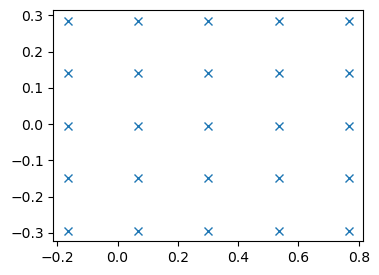

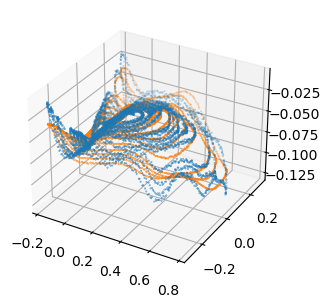

In [8]:
plot_model(model)